In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [2]:
import joblib
from skimage.io import imread
from skimage.transform import resize
 
def resize_all(src, pklname, include, width=150, height=None, count=100):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1}) beverage images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
            i = 0
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'} or file[-4:] in {'jpeg'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    if(im.shape != (width, height, 3)):
                        continue
                    if(i >= count):
                        break
                    data['label'].append(subdir)
                    data['filename'].append(file)
                    data['data'].append(im)
                    i += 1
 
        joblib.dump(data, pklname)

In [3]:
data_path = fr'Drinks/train'
base_name = 'beverages'
width = 120
include = {'beer', 'coffee'}
count = 300

In [4]:
resize_all(src=data_path, pklname=base_name, width=width, include=include, count=count)

beer
coffee


In [5]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  600
keys:  ['description', 'label', 'filename', 'data']
description:  resized (120x120) beverage images in rgb
image shape:  (120, 120, 3)
labels: ['beer' 'coffee']


Counter({'beer': 300, 'coffee': 300})

(120, 120, 3)

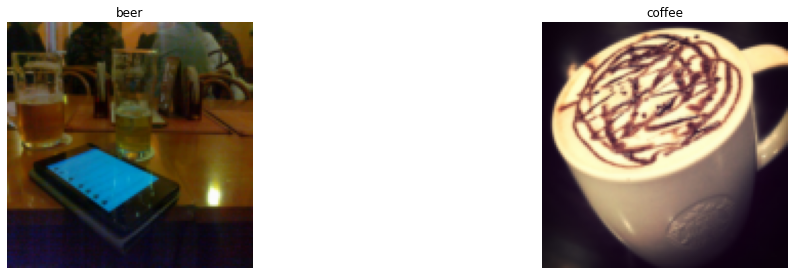

In [6]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)
    
    
data['data'][0].shape

In [7]:
X = np.array(data['data'])
print(X.shape)
y = np.array(data['label'])
print(y.shape)

(600, 120, 120, 3)
(600,)


In [8]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self 
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(8, 8), 
    cells_per_block=(4,4), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()

In [10]:
# import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import datasets


In [11]:
# transform the data

X = np.array(data['data'])
y = np.array(data['label'])

test_gray = grayify.fit_transform(X)
test_hog = hogify.fit_transform(test_gray)
test_prepared = scalify.fit_transform(test_hog)

In [12]:
#import and set all models

#SGD Model
from sklearn.linear_model import SGDClassifier 
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3, loss="hinge")

#SVM Models
from sklearn import svm
lin_clf = svm.SVC(kernel='linear', C=1)
poly_clf = svm.SVC(kernel='poly')
rbf_clf = svm.SVC(kernel='rbf')

#KNN Model
from sklearn.neighbors import KNeighborsClassifier
neigh_clf = KNeighborsClassifier(n_neighbors=10)

#Decision Tree Model
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()


In [13]:
#run each model with x folds and output results
cv = 10

#SGD
sgd_scores = cross_val_score(sgd_clf, test_prepared, y, cv=cv)
print("SGD:")
print(sgd_scores)
print(sgd_scores.mean())

SGD:
[0.73333333 0.68333333 0.71666667 0.7        0.61666667 0.8
 0.83333333 0.75       0.81666667 0.85      ]
0.7499999999999999


In [14]:
#SVM_Linear
lin_scores = cross_val_score(lin_clf, test_prepared, y, cv=cv)
print("SVM_Linear:")
print(lin_scores)
print(lin_scores.mean())


SVM_Linear:
[0.71666667 0.7        0.65       0.73333333 0.61666667 0.8
 0.85       0.78333333 0.81666667 0.88333333]
0.7549999999999999


In [15]:
#SVM_Polynomial
poly_scores = cross_val_score(poly_clf, test_prepared, y, cv=cv)
print("SVM_Polynomial:")
print(poly_scores)
print(poly_scores.mean())

SVM_Polynomial:
[0.53333333 0.53333333 0.55       0.58333333 0.5        0.61666667
 0.56666667 0.58333333 0.56666667 0.61666667]
0.5650000000000001


In [16]:
#SVM_RBF
rbf_scores = cross_val_score(rbf_clf, test_prepared, y, cv=cv)
print("SVM_RBF:")
print(rbf_scores)
print(rbf_scores.mean())

SVM_RBF:
[0.73333333 0.81666667 0.75       0.76666667 0.73333333 0.8
 0.91666667 0.71666667 0.86666667 0.83333333]
0.7933333333333332


In [17]:
#KNN
neigh_scores = cross_val_score(neigh_clf, test_prepared, y, cv=cv)
print("K-Nearest-Neighbor:")
print(neigh_scores)
print(neigh_scores.mean())

K-Nearest-Neighbor:
[0.66666667 0.61666667 0.71666667 0.71666667 0.61666667 0.71666667
 0.75       0.71666667 0.78333333 0.68333333]
0.6983333333333335


In [18]:
#Decision Tree
dt_scores = cross_val_score(dt_clf, test_prepared, y, cv=cv)
print("Decision Tree:")
print(dt_scores)
print(dt_scores.mean())

Decision Tree:
[0.51666667 0.58333333 0.58333333 0.63333333 0.55       0.61666667
 0.65       0.63333333 0.68333333 0.58333333]
0.6033333333333334


{'whiskers': [<matplotlib.lines.Line2D at 0x1ab3f04f940>,
 'caps': [<matplotlib.lines.Line2D at 0x1ab3f05a040>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ab3f04f5e0>,
 'medians': [<matplotlib.lines.Line2D at 0x1ab3f05a700>,
 'fliers': [<matplotlib.lines.Line2D at 0x1ab3f05aa60>,
 'means': []}

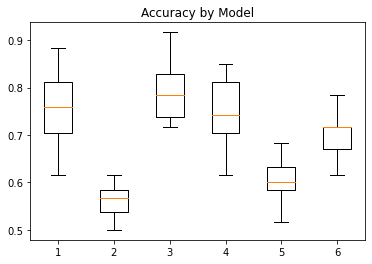

In [19]:
import matplotlib.pyplot as plt
data = [lin_scores, poly_scores, rbf_scores, sgd_scores, dt_scores, neigh_scores]

fig1, ax1 = plt.subplots()
ax1.set_title('Accuracy by Model')
ax1.boxplot(data)

In [20]:
rbf_clf = svm.SVC(kernel='rbf')

rbf_clf.fit(test_prepared, y)


SVC()

In [21]:
data_path = fr'TestFile'
print(os.listdir(data_path))
base_name = 'drinksTest'
width = 120

include = {'drinktest'}
resize_all(src=data_path, pklname=base_name, width=width, include=include, count=1)


['drinktest', 'wolftest']
drinktest


In [22]:
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ')
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

X = np.array(data['data'])
X.reshape(1,-1)
print(X.shape)

actual_gray = grayify.transform(X)
actual_hog = hogify.transform(actual_gray)
actual_prepared = scalify.transform(actual_hog)
print(actual_prepared)


number of samples:  1
keys:  ['description', 'label', 'filename', 'data']
description:  resized (120x120) beverage images in rgb
image shape: 
labels: ['drinktest']
(1, 120, 120, 3)
[[-0.73813992 -0.58113077 -0.3600849  ...  0.07859705  0.13888154
  -0.13457922]]


['beer']


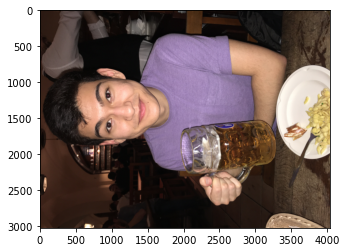

In [23]:
import matplotlib.image as mpimg
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
X = np.array(data['data'])
X.reshape(1,-1)

actual_gray = grayify.transform(X)
actual_hog = hogify.transform(actual_gray)
actual_prepared = scalify.transform(actual_hog)

img = mpimg.imread('TestFile/drinktest/image.jpg')
imgplot = plt.imshow(img)
y_pred = rbf_clf.predict(actual_prepared)
print(y_pred)
